# Проект по детекции дыма или огня на изображениях

### ===========================================
### Часть 1: импорт необходимых библиотек и функций
### ===========================================

In [1]:
# Загружаю библиотеки для работы
import os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

2025-07-13 14:50:31.803579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752418231.988049      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752418232.040102      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Скачиваю и импортирую вспомогательные функции
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves

--2025-07-13 14:54:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-07-13 14:54:58 (16.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### ===========================================
### Часть 2: загрузка данных и предобработка
### ===========================================

In [3]:
# Задам функцию сбора изображений
def collect_image_paths(dataset_dirs):
    """
    Обходит указанные директории и собирает пути к изображениям и соответствующие метки.
    """
    image_exts = ['*.jpg', '*.JPG', '*.png']
    data = []
    for dir_path in dataset_dirs:
        for ext in image_exts:
            for img_path in Path(dir_path).rglob(ext):
                label = img_path.parent.name
                data.append({'Filepath': str(img_path), 'Label': label})
    return pd.DataFrame(data)

In [4]:
# Задам пути к папкам с данными
dataset_dirs = [
    "../input/fire-dataset/fire_dataset",
    "../input/fire-and-smoke-dataset",
    "../input/forest-fire",
    "../input/test-dataset",
    "../input/house-rooms-streets-image-dataset"
]

In [5]:
# Запущу сбор изображений
df = collect_image_paths(dataset_dirs)
print(f"Всего изображений: {len(df)}")
print(df.head())

Всего изображений: 44723
                                            Filepath            Label
0  ../input/fire-dataset/fire_dataset/non_fire_im...  non_fire_images
1  ../input/fire-dataset/fire_dataset/non_fire_im...  non_fire_images
2  ../input/fire-dataset/fire_dataset/non_fire_im...  non_fire_images
3  ../input/fire-dataset/fire_dataset/non_fire_im...  non_fire_images
4  ../input/fire-dataset/fire_dataset/non_fire_im...  non_fire_images


In [6]:
# Приведу метки к бинарному виду и перемешаю данные
label_map = {
    'non_fire_images': 0, 'fire_images': 1, 'smoke': 1, 'fire': 1, 'default': 0,
    'train_fire': 1, 'test_big': 1, 'train-smoke': 1, 'test_small': 1,
    '0': 0, '1': 1, 'street_data': 0, 'house_data': 0
}
df['Label'] = df['Label'].replace(label_map)
df = shuffle(df.reset_index(drop=True), random_state=42)
print("Уникальные метки после преобразования:", df['Label'].unique())

Уникальные метки после преобразования: [0 1]


/tmp/ipykernel_36/3081501144.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(label_map)


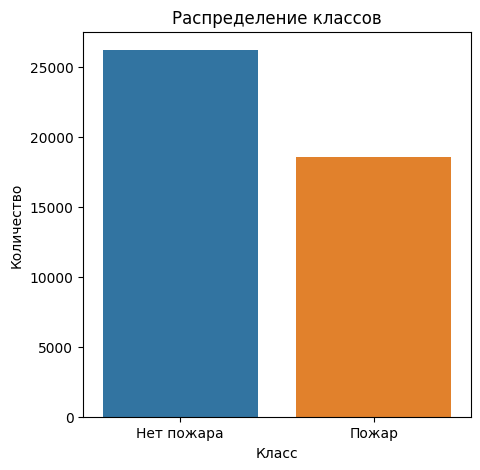

In [7]:
# Визуализирую распределение классов
plt.figure(figsize=(5, 5))
sns.countplot(x='Label', data=df)
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Нет пожара', 'Пожар'])
plt.show()

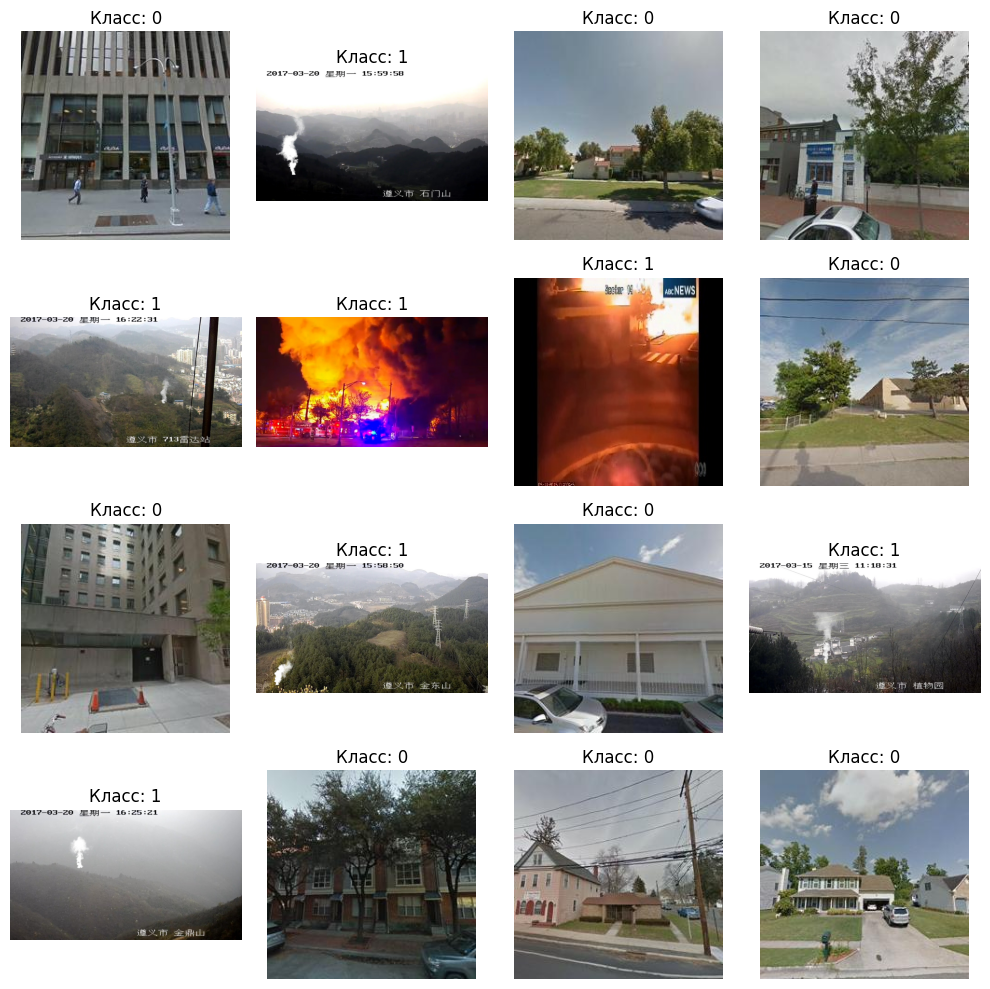

In [8]:
# Просмотрю случайные изображения, чтобы понять с чем имею дело
def plot_random_images(dataframe, n_images=16):
    """
    Показывает n_images случайных изображений из датафрейма.
    """
    idxs = np.random.choice(len(dataframe), n_images, replace=False)
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for ax, idx in zip(axes.flatten(), idxs):
        img = Image.open(dataframe.iloc[idx]['Filepath'])
        ax.imshow(img)
        ax.set_title(f"Класс: {dataframe.iloc[idx]['Label']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_random_images(df, 16)

In [9]:
# Разделю данные на обучающую и тестовую выборки
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)
print(f"Размер train: {len(train_df)}, test: {len(test_df)}")

Размер train: 35778, test: 8945


### ===========================================
### Часть 3: подготовка архитекруры модели
### ===========================================

In [10]:
# Подготовлю генераторы изображений
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw',
    subset='training',
    shuffle=True,
    seed=42
)
val_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw',
    subset='validation',
    shuffle=True,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

Found 28623 validated image filenames.
Found 7155 validated image filenames.
Found 8945 validated image filenames.


In [11]:
# Задам архитектуру модели (MobileNetV2 + классификатор)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Замораживаю веса базовой модели

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

I0000 00:00:1752419537.996400      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752419537.997118      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651,969 (10.12 MB)

 Trainable params: 393,985 (1.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Настрою callbacks
checkpoint_cb = ModelCheckpoint(
    'best_fire_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'
)
earlystop_cb = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=1
)

### ===========================================
### Часть 4: обучение модели
### ===========================================

In [13]:
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[
        earlystop_cb,
        checkpoint_cb,
        create_tensorboard_callback("logs", "fire_detection")
    ]
)

Saving TensorBoard log files to: logs/fire_detection/20250713-151348


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1752419637.109408     120 service.cc:148] XLA service 0x7fa0d0111de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752419637.110203     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752419637.110223     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752419638.061440     120 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752419642.988076     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9631 - loss: 0.1103

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


895/895 ━━━━━━━━━━━━━━━━━━━━ 416s 450ms/step - accuracy: 0.9631 - loss: 0.1102 - val_accuracy: 0.9934 - val_loss: 0.0203
Epoch 2/15
895/895 ━━━━━━━━━━━━━━━━━━━━ 188s 210ms/step - accuracy: 0.9920 - loss: 0.0218 - val_accuracy: 0.9957 - val_loss: 0.0139
Epoch 3/15
895/895 ━━━━━━━━━━━━━━━━━━━━ 167s 186ms/step - accuracy: 0.9959 - loss: 0.0134 - val_accuracy: 0.9962 - val_loss: 0.0131
Epoch 4/15
895/895 ━━━━━━━━━━━━━━━━━━━━ 164s 183ms/step - accuracy: 0.9973 - loss: 0.0080 - val_accuracy: 0.9957 - val_loss: 0.0138
Epoch 5/15
895/895 ━━━━━━━━━━━━━━━━━━━━ 166s 185ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9964 - val_loss: 0.0131
Epoch 6/15
895/895 ━━━━━━━━━━━━━━━━━━━━ 164s 183ms/step - accuracy: 0.9987 - loss: 0.0039 - val_accuracy: 0.9961 - val_loss: 0.0159
Epoch 7/15
895/895 ━━━━━━━━━━━━━━━━━━━━ 168s 188ms/step - accuracy: 0.9989 - loss: 0.0033 - val_accuracy: 0.9972 - val_loss: 0.0107
Epoch 8/15
895/895 ━━━━━━━━━━━━━━━━━━━━ 167s 186ms/step - accuracy: 0.9995 - loss: 0.00

### ===========================================
### Часть 5: результаты и визуализация обучения
### ===========================================

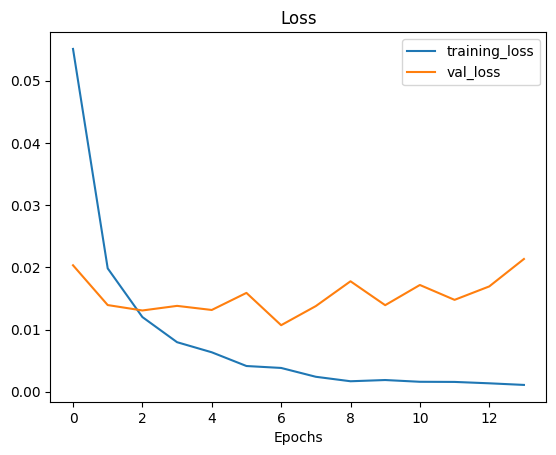

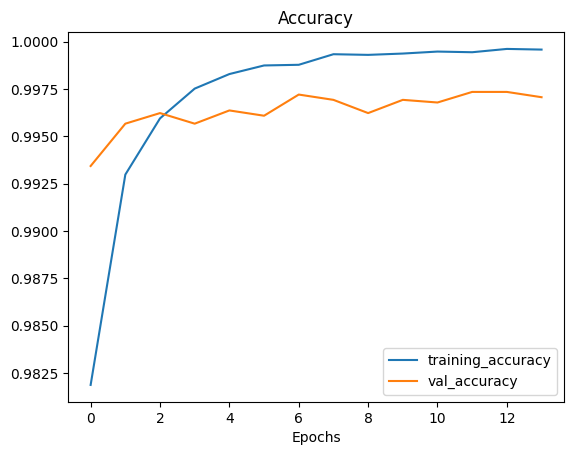

In [14]:
# Выведу графики обучения
plot_loss_curves(history)

280/280 ━━━━━━━━━━━━━━━━━━━━ 106s 368ms/step

=== Классификационный отчёт ===
              precision    recall  f1-score   support

  Нет пожара       1.00      1.00      1.00      5235
       Пожар       1.00      1.00      1.00      3710

    accuracy                           1.00      8945
   macro avg       1.00      1.00      1.00      8945
weighted avg       1.00      1.00      1.00      8945


=== Матрица ошибок ===


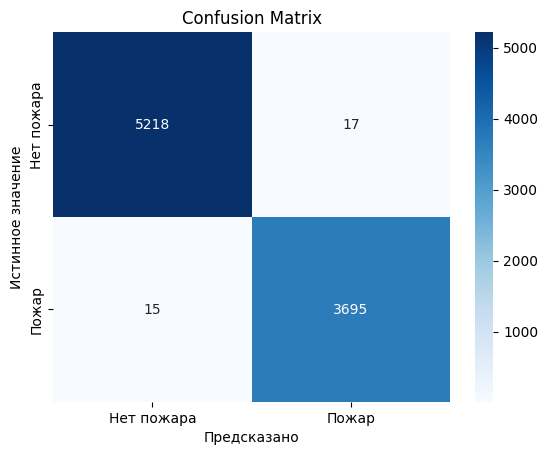

In [15]:
# Оценю качество модели на тестовой выборке
test_gen.reset()
preds = model.predict(test_gen)
y_true = test_df['Label'].values
y_pred = (preds > 0.5).astype(int).flatten()

print("\n=== Классификационный отчёт ===")
print(classification_report(y_true, y_pred, target_names=['Нет пожара', 'Пожар']))

print("\n=== Матрица ошибок ===")
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Нет пожара', 'Пожар'], yticklabels=['Нет пожара', 'Пожар'])
plt.xlabel('Предсказано')
plt.ylabel('Истинное значение')
plt.title('Confusion Matrix')
plt.show()

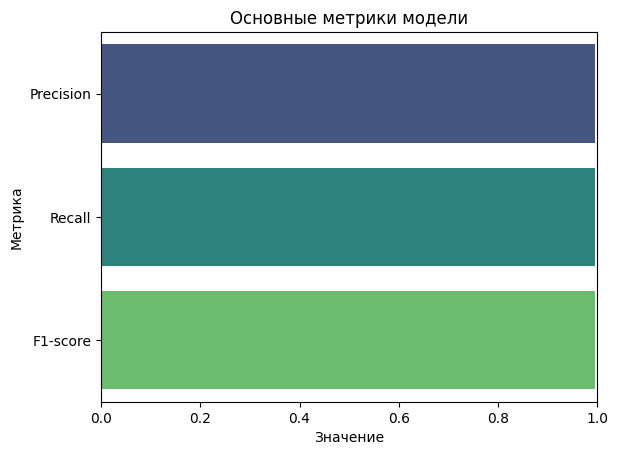

In [16]:
# Визуализирую метрики качества модели
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

metrics = pd.DataFrame({
    'Метрика': ['Precision', 'Recall', 'F1-score'],
    'Значение': [precision, recall, f1]
})

sns.barplot(x='Значение', y='Метрика', data=metrics, palette='viridis')
plt.title('Основные метрики модели')
plt.xlim(0, 1)
plt.show()

### ===========================================
### Часть 6: демонстрация работы модели на случайных тестовых изображениях
### ===========================================

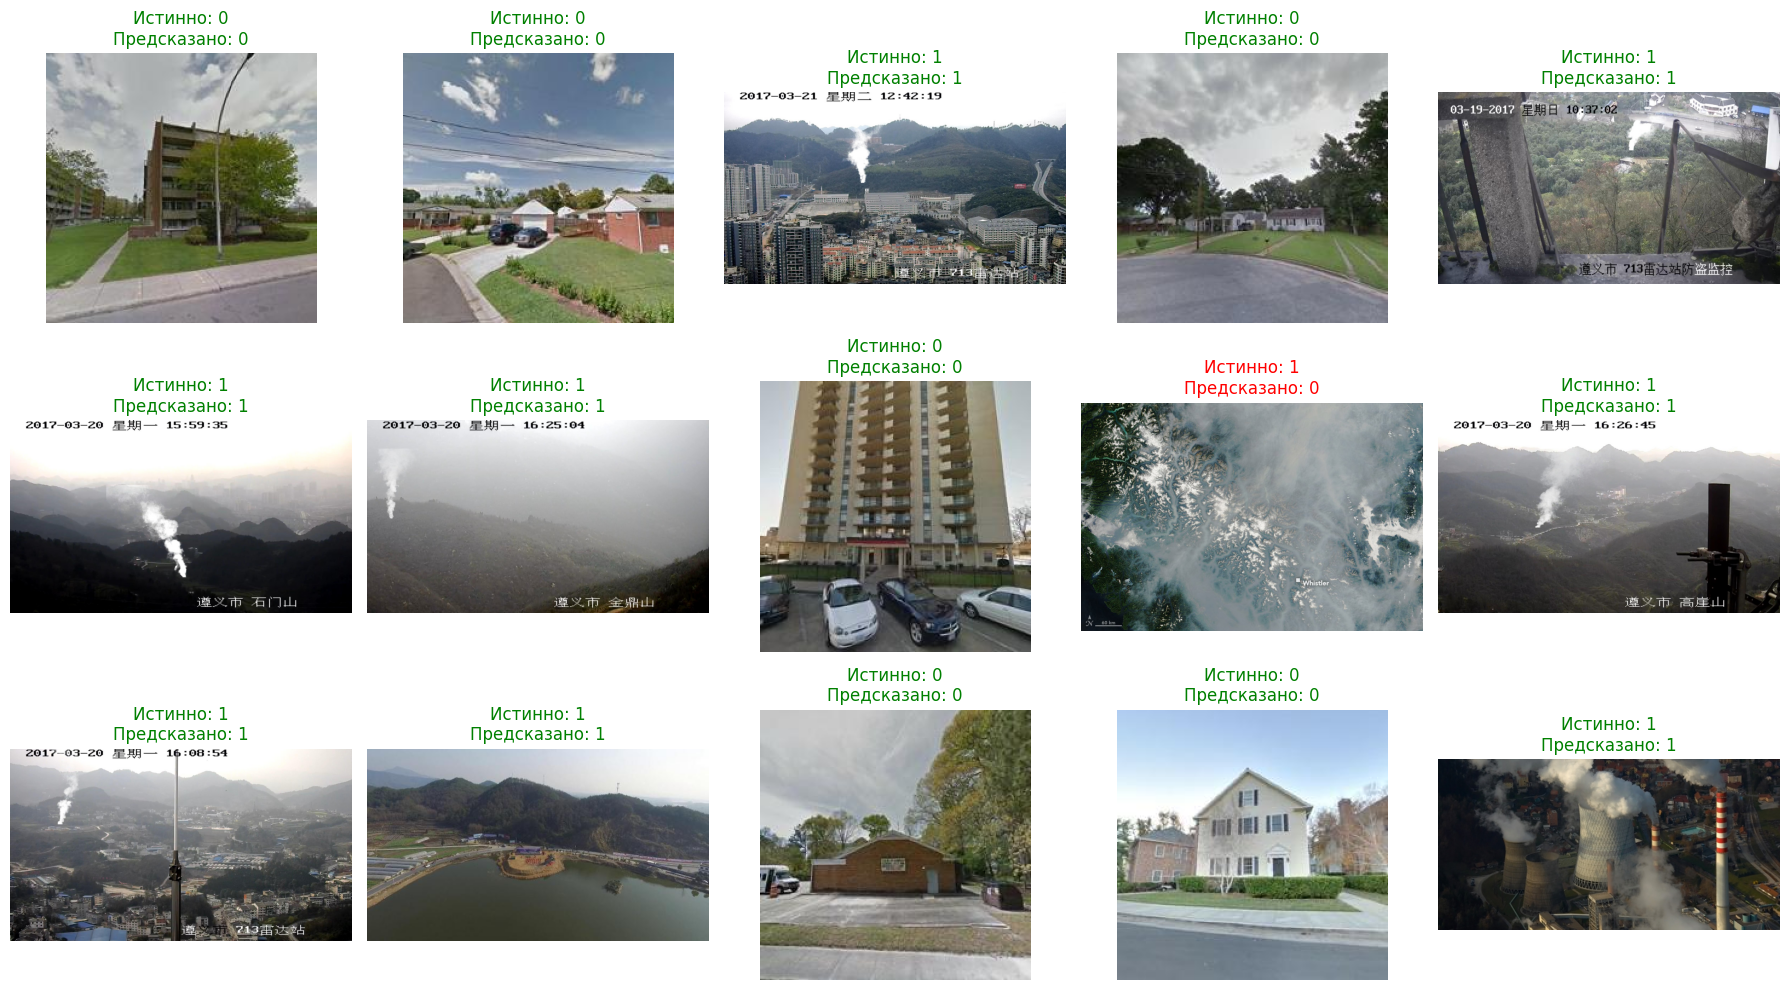

In [17]:
# Покажу работу модели на тестовых изображениях
def show_predictions(test_df, y_true, y_pred, n_images=15):
    idxs = np.random.choice(len(test_df), n_images, replace=False)
    fig, axes = plt.subplots(3, 5, figsize=(18, 10))
    for ax, idx in zip(axes.flatten(), idxs):
        img = Image.open(test_df.iloc[idx]['Filepath'])
        ax.imshow(img)
        true_lbl = y_true[idx]
        pred_lbl = y_pred[idx]
        color = 'green' if true_lbl == pred_lbl else 'red'
        ax.set_title(f"Истинно: {true_lbl}\nПредсказано: {pred_lbl}", color=color)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(test_df, y_true, y_pred, n_images=15)

### ===========================================
### Часть 7: сохранение весов модели
### ===========================================

In [19]:
# Сохраню веса модели
model.save_weights('fire_detector.weights.h5')